In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
from dataclasses import asdict
from copy import copy

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.theory.xs import SLBW

import importlib

In [2]:
%matplotlib widget

The capture cross-section is related to the capture yield (Y) by:

$Y_{\gamma} = \frac{\sigma_{\gamma}}{\sigma_{total}} (1-e^{-n\sigma_{total}}) $



## Data reduction

Data reduction describes calculating the capture yield ($Y$)from a set of experimental measurements.
The following equation describes the relationship between capture yield and measurement data:

$Y_{\gamma} = f_n \frac{\dot{c}_{\gamma} - \dot{c}_{bg}} {\phi} $

For now, let's continue to assume the background function is a constant function at 15 counts and let $f_n = 1$.

The $\phi$ term describes the incident neutron flux on the target and is measured in a separate experiment where the flux shape is determined by measuring detector count rates, subtracting background, and then normalizing by the yield of a well known sample. In many experiments, that well known sample is $B_4C$. The $(n,\alpha\gamma)$ cross section for $B^{10}$ is well characterized and there are no competing photon reactions below 1 MeV. More specifically, the characteristic prompt $\gamma$ at 478 KeV emitted from the $B^{10}(n,\alpha\gamma)$ reaction is measured by a C6D6 detector system. 

The data reduction for this flux measurment is given by:

$\phi = \frac{\dot{c}_{i, B_4C} - \dot{b}_{i, B_4C}} {Y_{i, B_4C}}$

Which leads to the complete data reduction equation:

$Y_{\gamma} = f_n \frac{(\dot{c}_{\gamma} - \dot{c}_{bg}) Y_{i, B_4C}} {\dot{c}_{i, B_4C} - \dot{b}_{i, B_4C}} $

Eventually, we will want to use a real measured count spectrum ($\dot{c}_{i, B_4C}$) from an experiment. 
We will then use MCNP to estimate ${Y_{i, B_4C}}$, or as an intermediate step we can take the normalized cross-section (Aaron's great idea!).
For now, we don't have access to a count spectrum for a $B_4C$ sample. 

But, we do have a different measurement of the flux spectrum ($\phi_i$) from the RPI facility.
This measurement (now included in this folder) is just an open measurement of the flux with a Li6 glass detector.
The ATARI.syndat function approximate_open_spectra() approximates this spectrum with a fitted exponential and can be used to generate realistic flux spectra. 
In this case, however, a $B_4C$ sample was not present. 
So instead on normalizing to ${Y_{i, B_4C}}$, we should normalize to the tritium yield of the Li6 glass detector ${Li^6(n,t)}$ as this is the reaction that causes scintilation and ultimately a signal.

$\phi = \frac{\dot{c}_{i, Li6} - \dot{b}_{i, Li6}} {Y_{i, Li6}}$


<!-- Other variables we may need in the future -->
<!-- | trigo     |      9758727              |   0                         |   -->
<!-- | trigs     |      18476117             |   0                         |   -->
<!-- | t0        |      3.32                 |   0                         |   -->
<!-- | bw        |      0.006                |   0                         |   -->
<!-- | m1        |      1                    |   0.016                     |       -->
<!-- | m2        |      1                    |   0.008                     |       -->
<!-- | m3        |      1                    |   0.018                     |       -->
<!-- | m4        |      1                    |   0.005                     |       -->    
<!-- | ks        |      0.56                 |   0.02402339737495515       |                   -->
<!-- | ko        |      1.47                 |   0.05576763648617445       |                   -->
<!-- | b0s       |      9.                   |   0.1                       |   -->
<!-- | b0o       |      13.                  |   0.7                       |   -->


In [15]:
ac=0.81271; M=180.948030; m=1; I=3.5; i=0.5; l_max=1     

E_min_max = [5, 2000]
experiment_parameters = {'bw': {'val':0.1024,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}
exp = Experiment(E_min_max,  
                        experiment_parameters=experiment_parameters)


Text(0.5, 0, 'E')

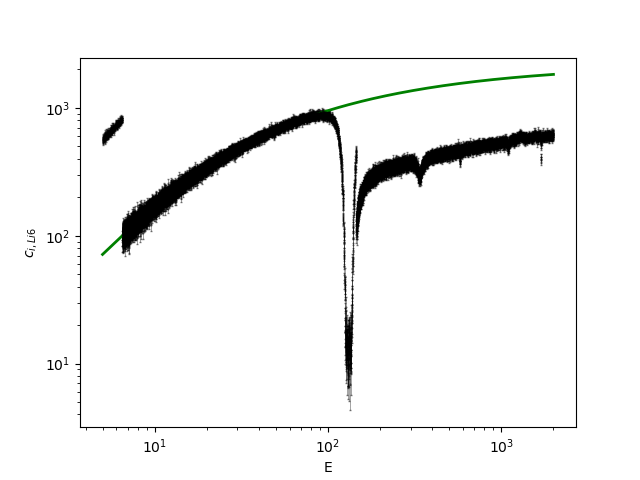

In [16]:
from ATARI.syndat import exp_effects

t0 = 3.326
FP = 35.185
trig = 9758727

### function to compare to real open spectrum from RPI
open_data = "./openspec.csv"
measured_odat = pd.read_csv(open_data, sep=',')
measured_odat['E'] = exp_effects.t_to_e((measured_odat.tof-t0)*1e-6, FP, True) 
measured_odat['bw'] = measured_odat.bin_width*1e-6 
measured_odat.rename(columns={"counts": "c", "dcounts": "dc"}, inplace=True)
measured_odat = measured_odat[(measured_odat.E>min(E_min_max)) & (measured_odat.E<max(E_min_max))]

### Fitted open spectrum function from Syndat - smooth_open=True will return a smooth function while False will return a noisy function
fit_odat = exp.approximate_open_spectra(exp.energy_domain,smooth_open=True)

figure()
errorbar(measured_odat.E, measured_odat.c, yerr=measured_odat.dc, color='k', fmt='.', ms=1, linewidth=0.5, capsize=0.5, alpha=0.5)
plot(fit_odat.E, fit_odat.c, 'g', lw=2)
yscale('log'); xscale('log')
ylabel(r'$c_{i, Li6}$'); xlabel('E')


### Counts to count rates

Notice that the function above returns counts rather than count rates, this is why there seems to be step changes in the counts observed.
Count rates are calculated by dividing the number of counts in a tof bin by the amount of time that bin was collecting data.
This is given by the following equation where bw is the time-width of bin $i$ and trig is the integer number of times the target saw a burst of neutrons.

$\dot{c_i} = \frac{c_i}{bw_i trig}$

The function ATARI.syndat.exp_effects.cts_to_ctr can be used to do this conversion. 
This function also propagates the uncertainty in counts to count rate.
For the synthetic data generation, you should convert to counts before sampling poisson noise, then convert back to count rates.

Text(0.5, 0, 'E')

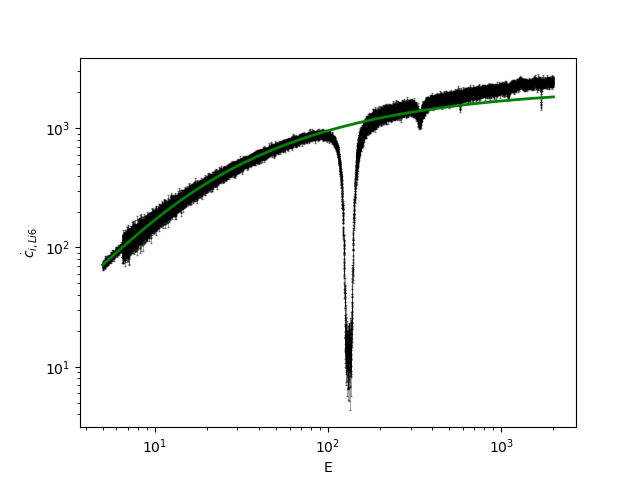

In [22]:
measured_odat["cps"], measured_odat["dcps"] = exp_effects.cts_to_ctr(measured_odat.c, measured_odat.dc, measured_odat.bw, trig)

fit_odat["cps"], _ = exp_effects.cts_to_ctr(fit_odat.c, fit_odat.dc, fit_odat.bw, trig)

figure()
errorbar(measured_odat.E, measured_odat.cps, yerr=measured_odat.dcps, color='k', fmt='.', ms=1, 
                                        linewidth=0.5, capsize=0.5, alpha=0.5, zorder=0)
plot(fit_odat.E, fit_odat.cps, 'g', lw=2, zorder=2)
yscale('log')
xscale('log')
ylabel(r'$\dot{c}_{i, Li6}$')
xlabel('E')

### Blackout resonance

The feature in the open spectra at around 132 eV is not naturally occuring in the flux spectrum.
In this case, a Co sample was present to 'blackout' the count rate at one point in order to estimate the background.
This energy region is ignored in an actuality, for out synthetic data, we can use the green fitted line as true (ignore the black resonance) and sample around it to get a synthetic 'measurement' of the flux.
The above plots are just to show you waht actual flux data looks like. 

# Generating synthetic data

If the data reduction process is:

$Y_{\gamma} = f_n \frac{(\dot{c}_{\gamma} - \dot{c}_{bg}) Y_{i, Li6}} {\dot{c}_{i, Li6} - \dot{b}_{i, Li6}} $

Then the 'inverse data reduction process' can be used to generate expected observables ($\dot{c}_{\gamma}$) from a true capture yield:

$\dot{c}_{\gamma} = \frac{Y_{\gamma} (\dot{c}_{i, Li6} - \dot{b}_{i, Li6})}{f_n Y_{i, Li6}} + \dot{c}_{bg} $

In order to calculate $\dot{c}_{\gamma}$, all other parameters must be known. 
Other that the capture yield, these parameters will be referred to as reduction parameters. 
For each reduction parameters, we have some estimate of the value and uncertainty that is used for data reduction.
In the inverse reduction (or generation), the estimated value and uncertainty of data reduction parameters are used to sample a set of 'true underlying reduction parameters' or TURPs.
The TURPs are used for the data generation, then the estimated value and uncertainty is used for data reduction.

## Improving what you have so far

1. Read in the Li6 Yield
The csv files Li6_nT and Li6_ntot contain the (n,tritium) and (n,total) cross-sections respectively.
Calculate the expected tritium yield using the yield equation from earlier and take this to be fixed (a neutron data standard).
You will have to linearly interpolate on the provided grid to be on the experimental grid you want to use.

2. Generate $\phi$ for our experiment
Take the yield $Y_{i, Li6}$ as fixed always, sample the count spectrum and background ($\dot{c}_{i, Li6}, \dot{b}_{i, Li6}$) around the true vector. For count spectrum, this can be done using the approximate_open_spectra(exp.energy_domain, smooth_open=False).

3. Plug these into the existing methodology for synthetic data generation
Use the function structure I've outlined below, this will help me integrate your code into Syndat.

(1, 4000.0)

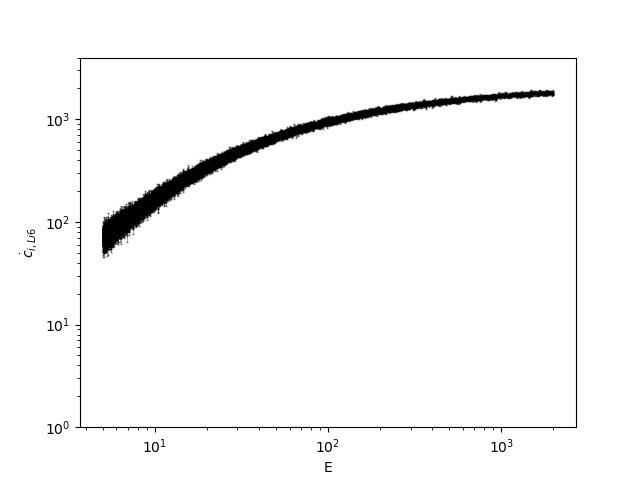

In [26]:
## put your code here, a starting point with the open spectra:

measured_odat = exp.approximate_open_spectra(exp.energy_domain, smooth_open=False)
measured_odat["cps"], measured_odat["dcps"] = exp_effects.cts_to_ctr(measured_odat.c, measured_odat.dc, measured_odat.bw, trig)

figure()
errorbar(measured_odat.E, measured_odat.cps, yerr=measured_odat.dcps, color='k', fmt='.', ms=1, 
                                        linewidth=0.5, capsize=0.5, alpha=0.5, zorder=0)
yscale('log')
xscale('log')
ylabel(r'$\dot{c}_{i, Li6}$')
xlabel('E')
ylim([1,4e3])

### Example functions

Below, the term 'reduction parameters' refers to the experimentally estimated values, i.e., $f_n$, background counts, flux.

In [6]:
def sample_true_underlying_reduction_parameters(estimated_reduction_parameters, estimated_reduction_parameter_uncertainty):
    """This function should take the estimated parameters used in data reduction and sample them to get 'true' values used in the generation.
    This includes estimates of the flux, background, and normalization (fn)"""
    return true_reduction_parameters

def inverse_reduction(true_capture_yield, true_reduction_parameters):
    return true_gamma_counts

def generate(true_capture_yield, estimated_reduction_parameters, estimated_reduction_parameter_uncertainty, 
                                                                    option_to_sample_TURP,
                                                                    option_to_sample_noise):
    """ This function should take in a pointwise representation of the true capture yield and return a pointwise set of noisy gamma counts (c_gamma)"""

    # should call functions to sample true underlying reduction parameters for generation of true gamma counts
    if option_to_sample_TURP:
        true_reduction_parameters = sample_true_underlying_reduction_parameters(estimated_reduction_parameters, estimated_reduction_parameter_uncertainty)
    
    # calculate true_gamma_counts using true underlying reduction parameters
    true_gamma_counts = inverse_reduction(true_capture_yield, true_reduction_parameters)

    # if option_to_sample_noise then sample poisson noise around true gamma counts to give gamma_counts - this should be a pandas dataframe with columns E, cts, dcts
    return gamma_counts




def reduce(gamma_counts, estimated_reduction_parameters, estimated_reduction_parameter_uncertainty):
    """This function should take in a pointwise set of noisy gamma_counts (c_gamma) and perform the data reduction process"""

    # convert gamma_counts to capture yield using estimated_reduction_parameters

    # propagate uncertainty from gamma_counts and estimated_reduction_parameters

    return #capture_yield
